In [2]:
import pandas as pd
import numpy as np
import os

import json

class Config():

    def __init__(self,fconfig):
        config = json.load(fconfig)
        self.name_main_sample = config['name_sample']
        self.name_sample = config['name_sample'] + config['additional_name']
        self.general_path = config['general_path']
        self.data_path = config['data_path']
        self.prediction_path = config['prediction_path']
        self.test_path = config['test_path'] ############
        self.flags = config['flags']
        self.hyperparam = config['hyperparam']
        self.features = config['features']
        self.name_class = config['name_class']
        self.name_class_column = config["name_class_column"]
        self.base = config["base"]
        self.picture = config['picture']
        self.statistic = config['statistic']
        #
        self.path_ml_data = f'{self.general_path}/ml/data'
        self.path_ml = f'{self.general_path}/ml'
        self.path_sample = f'{self.general_path}/sample'
        self.path_pic = f'{self.general_path}/ml/picture'
        self.path_stat = f'{self.general_path}/statistic'
        #
        self.path_model = f"{self.path_ml}/model/mod_{self.name_sample}"
        self.path_weight = f"{self.path_ml}/model/weight_{self.name_sample}"
        self.path_eval = f"{self.path_ml}/eval/{self.name_sample}"
        self.path_predict = f"{self.path_ml}/prediction/{self.name_sample}"
        #
        columns = []
        columns_prob = []
        for col in self.name_class:
            columns.append(f"{col}_cls")
            columns_prob.append(f"{col}_cls_prob")
        self.name_class_cls = columns
        self.name_class_prob = columns_prob

In [3]:
fconfig = open('config_agn_sdss.json')
config = Config(fconfig)
fconfig.close()
del fconfig

In [4]:
from data_process import data_preparation

def select_data(config):
    #data = pd.DataFrame()
    #data preparation
    if(not config.flags['data_preprocessing']['work']):
        if(os.path.isfile(f'{config.path_ml_data}/{config.name_main_sample}_all.csv')):
            data = pd.read_csv(f'{config.path_ml_data}/{config.name_main_sample}_all.csv', header = 0, sep = ',')
        else:
            data = data_preparation(config.path_ml_data,config.path_sample,config.name_class,config)
    else:
        data = data_preparation(config.path_ml_data,config.path_sample,config.name_class,config)
    
    return data

In [5]:
data = select_data(config)

data

,RA,DEC,z,z_err,angDist,angDist.1,PQSO,PGal,PSS,nW1,...,mcd_d,mcd_g,fuzzy_err,fuzzy_dist,qso_cls,agn_cls,sbg_cls,sfg_cls,gal_cls,star_cls
0,239.177460,27.055966,0.090353,0.000027,0.086462,0.171325,0.000000,1.000000,0.000000,12,...,2.357481,0.340302,0.687168,0.787404,0,0,0,0,1,0
1,169.268150,4.427474,1.170077,0.000150,0.032336,0.068488,1.000000,0.000000,0.000000,12,...,0.837587,0.263093,0.681880,0.827843,1,0,0,0,0,0
2,43.250305,-3.342976,0.244153,0.000030,0.200110,0.594563,0.000336,0.013068,0.984260,13,...,1.140024,0.338401,0.654243,0.815071,0,0,0,0,1,0
3,172.780700,45.426833,1.229971,0.000552,0.045566,0.092679,0.999922,0.000000,0.000078,12,...,1.358093,0.379193,0.672553,0.808466,1,0,0,0,0,0
4,150.185940,2.474568,0.000868,0.000008,0.124031,0.150412,0.000000,0.000000,0.999934,12,...,0.739153,0.254910,0.702885,0.882802,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1090354,219.531190,15.218142,0.098927,0.000009,0.011590,0.030389,0.000000,1.000000,0.000000,13,...,2.128290,0.438617,0.677479,0.554826,0,0,0,1,0,0
1090355,9.150885,23.917155,2.520883,0.000440,0.045041,0.395291,1.000000,0.000000,0.000000,13,...,3.519597,0.078064,0.642015,0.640678,1,0,0,0,0,0
1090356,33.514822,6.673856,-0.000333,0.000012,0.065429,0.236262,0.000000,0.000000,0.999985,13,...,3.740190,0.071538,0.565084,0.879244,0,0,0,0,0,1
1090357,3.715578,4.087570,1.855977,0.000165,0.068224,0.877788,1.000000,0.000000,0.000000,13,...,1.609952,0.407870,0.639610,0.800421,1,0,0,0,0,0


In [6]:
import shap

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [7]:
from network import LoadModel,make_custom_index

name = f"custom_sm_{make_custom_index('00',config.hyperparam['model_variable']['neuron_count'])}"

model = LoadModel(f'{config.path_model}_{name}',f'{config.path_weight}_{name}',config.hyperparam['optimizer'],config.hyperparam['loss'])

2024-05-10 15:51:05.324206: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model is loaded from disk



In [10]:
from data_process import get_features
import time
#normalize data

#X,y = shap.datasets.adult()
X_train_test = data[get_features(config.features["train"],config)]
#print(X_train)
degree = np.sort(np.array([1,2,3,4,5,6]))
def f(x):
    #print(x)
    pred = model.predict(x)
    #rez = np.zeros(len(pred))
    #rez[:] = pred[:,:].dot(degree)
    #print(pred)
    rez = np.zeros((len(pred),1))
    rez[:,0] = np.apply_along_axis(np.argmax,axis=1,arr=pred)
    return rez
'''
#print(f(X_train.iloc[:10]))
#print(X_train.iloc[:10])
'''
#y_train_local = y_train[:,:].dot(degree)
#import xgboost
#clustering = shap.utils.hclust(X_train, y_train_local)
#masker = shap.maskers.Partition(X_train, clustering=clustering)
#explainer = shap.explainers.Exact(f,masker)
#shap_values = explainer(X_train.iloc[:100])
#shap.plots.bar(shap_values)
'''
'''
Test = X_train_test.sample(200, ignore_index=True)

explainer = shap.explainers.Permutation(f,Test)
#explainer = shap.explainers.Permutation(f,Test)

#X_test = X_test.sample(200, ignore_index=True)
#


shap_values = explainer(Test)

#shap.plots.beeswarm(shap_values)

#explainer = shap.explainers.Exact(f, Test)
#shap_values = explainer(Test)

#print(shap_values)
#print(shap_values[0])

shap.plots.bar(shap_values)

#shap.plots.waterfall(shap_values[0])

#Test

['var', 'color']
50/50 [==============================] - 0s 357us/step


Permutation explainer:   0%|          | 7/2000 [00:00<?, ?it/s]

50/50 [==============================] - 0s 367us/step


Permutation explainer:   0%|          | 9/2000 [00:11<22:38,  1.47it/s]

50/50 [==============================] - 0s 355us/step


Permutation explainer:   0%|          | 10/2000 [00:12<31:57,  1.04it/s]

50/50 [==============================] - 0s 403us/step


Permutation explainer:   1%|          | 11/2000 [00:14<36:51,  1.11s/it]

50/50 [==============================] - 0s 373us/step


Permutation explainer:   1%|          | 12/2000 [00:15<39:45,  1.20s/it]

50/50 [==============================] - 0s 372us/step


Permutation explainer:   1%|          | 13/2000 [00:16<41:20,  1.25s/it]

50/50 [==============================] - 0s 378us/step


Permutation explainer:   1%|          | 14/2000 [00:18<42:32,  1.29s/it]

50/50 [==============================] - 0s 357us/step


Permutation explainer:   1%|          | 15/2000 [00:19<43:13,  1.31s/it]

50/50 [==============================] - 0s 407us/step


Permutation explainer:   1%|          | 16/2000 [00:20<43:50,  1.33s/it]

50/50 [==============================] - 0s 377us/step


Permutation explainer:   1%|          | 17/2000 [00:22<44:28,  1.35s/it]

50/50 [==============================] - 0s 392us/step


Permutation explainer:   1%|          | 18/2000 [00:23<44:44,  1.35s/it]

 1/96 [..............................] - ETA: 0s

Permutation explainer:   1%|          | 18/2000 [00:24<1:13:32,  2.23s/it]


KeyboardInterrupt: 

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


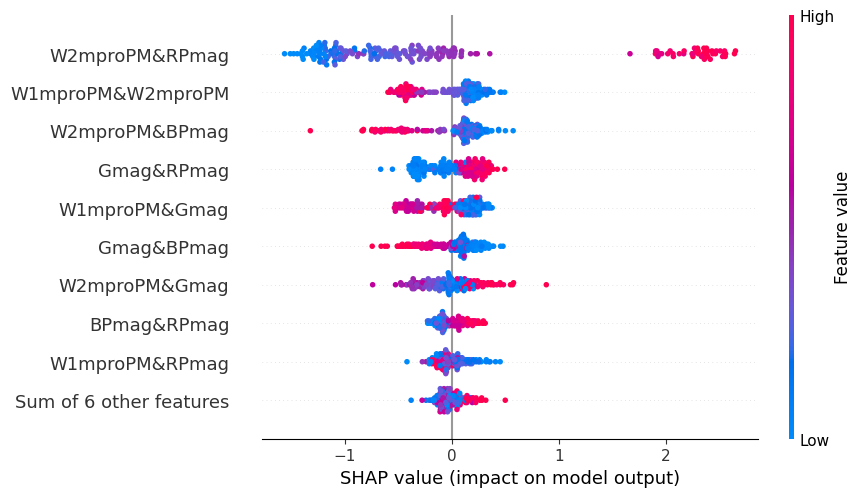

In [18]:
shap.plots.beeswarm(shap_values)

In [32]:
explainer_1 = shap.Explainer(f,Test)

shap_values_1 = explainer_1(Test)

50/50 [==============================] - 0s 492us/step


Permutation explainer:   3%|▎         | 6/200 [00:00<?, ?it/s]

50/50 [==============================] - 0s 488us/step


Permutation explainer:   4%|▍         | 8/200 [00:11<02:53,  1.11it/s]

50/50 [==============================] - 0s 424us/step


Permutation explainer:   4%|▍         | 9/200 [00:13<03:56,  1.24s/it]

50/50 [==============================] - 0s 463us/step


Permutation explainer:   5%|▌         | 10/200 [00:15<04:27,  1.41s/it]

50/50 [==============================] - 0s 599us/step


Permutation explainer:   6%|▌         | 11/200 [00:16<04:42,  1.49s/it]

50/50 [==============================] - 0s 568us/step


Permutation explainer:   6%|▌         | 12/200 [00:18<04:53,  1.56s/it]

50/50 [==============================] - 0s 650us/step


Permutation explainer:   6%|▋         | 13/200 [00:20<05:00,  1.61s/it]

50/50 [==============================] - 0s 475us/step


Permutation explainer:   7%|▋         | 14/200 [00:21<05:01,  1.62s/it]

50/50 [==============================] - 0s 501us/step


Permutation explainer:   8%|▊         | 15/200 [00:23<05:04,  1.64s/it]

50/50 [==============================] - 0s 471us/step


Permutation explainer:   8%|▊         | 16/200 [00:25<05:03,  1.65s/it]

50/50 [==============================] - 0s 467us/step


Permutation explainer:   8%|▊         | 17/200 [00:26<05:02,  1.65s/it]

50/50 [==============================] - 0s 483us/step


Permutation explainer:   9%|▉         | 18/200 [00:28<05:03,  1.67s/it]

50/50 [==============================] - 0s 493us/step


Permutation explainer:  10%|▉         | 19/200 [00:30<05:04,  1.68s/it]

50/50 [==============================] - 0s 439us/step


Permutation explainer:  10%|█         | 20/200 [00:32<05:02,  1.68s/it]

50/50 [==============================] - 0s 546us/step


Permutation explainer:  10%|█         | 21/200 [00:33<05:02,  1.69s/it]

50/50 [==============================] - 0s 470us/step


Permutation explainer:  11%|█         | 22/200 [00:35<05:01,  1.69s/it]

50/50 [==============================] - 0s 505us/step


Permutation explainer:  12%|█▏        | 23/200 [00:37<05:00,  1.70s/it]

50/50 [==============================] - 0s 560us/step


Permutation explainer:  12%|█▏        | 24/200 [00:38<05:01,  1.71s/it]

50/50 [==============================] - 0s 564us/step


Permutation explainer:  12%|█▎        | 25/200 [00:40<04:58,  1.70s/it]

50/50 [==============================] - 0s 457us/step


Permutation explainer:  13%|█▎        | 26/200 [00:42<04:55,  1.70s/it]

50/50 [==============================] - 0s 536us/step


Permutation explainer:  14%|█▎        | 27/200 [00:43<04:53,  1.69s/it]

50/50 [==============================] - 0s 510us/step


Permutation explainer:  14%|█▍        | 28/200 [00:45<04:47,  1.67s/it]

50/50 [==============================] - 0s 456us/step


Permutation explainer:  14%|█▍        | 29/200 [00:47<04:48,  1.69s/it]

50/50 [==============================] - 0s 509us/step


Permutation explainer:  15%|█▌        | 30/200 [00:49<04:47,  1.69s/it]

50/50 [==============================] - 0s 475us/step


Permutation explainer:  16%|█▌        | 31/200 [00:50<04:46,  1.70s/it]

50/50 [==============================] - 0s 496us/step


Permutation explainer:  16%|█▌        | 32/200 [00:52<04:42,  1.68s/it]

50/50 [==============================] - 0s 559us/step


Permutation explainer:  16%|█▋        | 33/200 [00:54<04:39,  1.67s/it]

50/50 [==============================] - 0s 600us/step


Permutation explainer:  17%|█▋        | 34/200 [00:55<04:36,  1.67s/it]

50/50 [==============================] - 0s 490us/step


Permutation explainer:  18%|█▊        | 35/200 [00:57<04:34,  1.66s/it]

50/50 [==============================] - 0s 535us/step


Permutation explainer:  18%|█▊        | 36/200 [00:59<04:33,  1.67s/it]

50/50 [==============================] - 0s 457us/step


Permutation explainer:  18%|█▊        | 37/200 [01:00<04:30,  1.66s/it]

50/50 [==============================] - 0s 373us/step


Permutation explainer:  19%|█▉        | 38/200 [01:02<04:33,  1.69s/it]

50/50 [==============================] - 0s 509us/step


Permutation explainer:  20%|█▉        | 39/200 [01:04<04:29,  1.67s/it]

50/50 [==============================] - 0s 571us/step


Permutation explainer:  20%|██        | 40/200 [01:05<04:31,  1.70s/it]

50/50 [==============================] - 0s 502us/step


Permutation explainer:  20%|██        | 41/200 [01:07<04:34,  1.73s/it]

50/50 [==============================] - 0s 524us/step


Permutation explainer:  21%|██        | 42/200 [01:09<04:39,  1.77s/it]

50/50 [==============================] - 0s 474us/step


Permutation explainer:  22%|██▏       | 43/200 [01:11<04:36,  1.76s/it]

50/50 [==============================] - 0s 535us/step


Permutation explainer:  22%|██▏       | 44/200 [01:12<04:27,  1.72s/it]

50/50 [==============================] - 0s 476us/step


Permutation explainer:  22%|██▎       | 45/200 [01:14<04:25,  1.71s/it]

50/50 [==============================] - 0s 453us/step


Permutation explainer:  23%|██▎       | 46/200 [01:16<04:19,  1.69s/it]

50/50 [==============================] - 0s 437us/step


Permutation explainer:  24%|██▎       | 47/200 [01:17<04:22,  1.72s/it]

50/50 [==============================] - 0s 530us/step


Permutation explainer:  24%|██▍       | 48/200 [01:19<04:20,  1.71s/it]

50/50 [==============================] - 0s 578us/step


Permutation explainer:  24%|██▍       | 49/200 [01:21<04:18,  1.71s/it]

50/50 [==============================] - 0s 602us/step


Permutation explainer:  25%|██▌       | 50/200 [01:23<04:17,  1.72s/it]

50/50 [==============================] - 0s 491us/step


Permutation explainer:  26%|██▌       | 51/200 [01:24<04:14,  1.71s/it]

50/50 [==============================] - 0s 525us/step


Permutation explainer:  26%|██▌       | 52/200 [01:26<04:11,  1.70s/it]

50/50 [==============================] - 0s 537us/step


Permutation explainer:  26%|██▋       | 53/200 [01:28<04:20,  1.77s/it]

50/50 [==============================] - 0s 486us/step


Permutation explainer:  27%|██▋       | 54/200 [01:30<04:19,  1.78s/it]

50/50 [==============================] - 0s 534us/step


Permutation explainer:  28%|██▊       | 55/200 [01:31<04:16,  1.77s/it]

50/50 [==============================] - 0s 512us/step


Permutation explainer:  28%|██▊       | 56/200 [01:33<04:13,  1.76s/it]

50/50 [==============================] - 0s 495us/step


Permutation explainer:  28%|██▊       | 57/200 [01:35<04:10,  1.75s/it]

50/50 [==============================] - 0s 433us/step


Permutation explainer:  29%|██▉       | 58/200 [01:37<04:09,  1.75s/it]

50/50 [==============================] - 0s 586us/step


Permutation explainer:  30%|██▉       | 59/200 [01:38<04:06,  1.75s/it]

50/50 [==============================] - 0s 493us/step


Permutation explainer:  30%|███       | 60/200 [01:40<04:03,  1.74s/it]

50/50 [==============================] - 0s 455us/step


Permutation explainer:  30%|███       | 61/200 [01:42<04:01,  1.74s/it]

50/50 [==============================] - 0s 519us/step


Permutation explainer:  31%|███       | 62/200 [01:44<03:58,  1.73s/it]

50/50 [==============================] - 0s 419us/step


Permutation explainer:  32%|███▏      | 63/200 [01:45<03:54,  1.72s/it]

50/50 [==============================] - 0s 520us/step


Permutation explainer:  32%|███▏      | 64/200 [01:47<03:53,  1.72s/it]

50/50 [==============================] - 0s 506us/step


Permutation explainer:  32%|███▎      | 65/200 [01:49<03:52,  1.72s/it]

50/50 [==============================] - 0s 539us/step


Permutation explainer:  33%|███▎      | 66/200 [01:50<03:50,  1.72s/it]

50/50 [==============================] - 0s 537us/step


Permutation explainer:  34%|███▎      | 67/200 [01:52<03:47,  1.71s/it]

50/50 [==============================] - 0s 495us/step


Permutation explainer:  34%|███▍      | 68/200 [01:54<03:45,  1.71s/it]

50/50 [==============================] - 0s 513us/step


Permutation explainer:  34%|███▍      | 69/200 [01:56<03:44,  1.71s/it]

50/50 [==============================] - 0s 542us/step


Permutation explainer:  35%|███▌      | 70/200 [01:57<03:42,  1.71s/it]

50/50 [==============================] - 0s 603us/step


Permutation explainer:  36%|███▌      | 71/200 [01:59<03:41,  1.71s/it]

50/50 [==============================] - 0s 541us/step


Permutation explainer:  36%|███▌      | 72/200 [02:01<03:40,  1.72s/it]

50/50 [==============================] - 0s 469us/step


Permutation explainer:  36%|███▋      | 73/200 [02:02<03:39,  1.72s/it]

50/50 [==============================] - 0s 543us/step


Permutation explainer:  37%|███▋      | 74/200 [02:04<03:37,  1.73s/it]

50/50 [==============================] - 0s 521us/step


Permutation explainer:  38%|███▊      | 75/200 [02:06<03:36,  1.73s/it]

50/50 [==============================] - 0s 453us/step


Permutation explainer:  38%|███▊      | 76/200 [02:08<03:33,  1.72s/it]

50/50 [==============================] - 0s 424us/step


Permutation explainer:  38%|███▊      | 77/200 [02:09<03:28,  1.70s/it]

50/50 [==============================] - 0s 560us/step


Permutation explainer:  39%|███▉      | 78/200 [02:11<03:26,  1.69s/it]

50/50 [==============================] - 0s 622us/step


Permutation explainer:  40%|███▉      | 79/200 [02:13<03:25,  1.70s/it]

50/50 [==============================] - 0s 610us/step


Permutation explainer:  40%|████      | 80/200 [02:14<03:23,  1.70s/it]

50/50 [==============================] - 0s 658us/step


Permutation explainer:  40%|████      | 81/200 [02:16<03:21,  1.69s/it]

50/50 [==============================] - 0s 406us/step


Permutation explainer:  41%|████      | 82/200 [02:18<03:18,  1.68s/it]

50/50 [==============================] - 0s 488us/step


Permutation explainer:  42%|████▏     | 83/200 [02:19<03:15,  1.67s/it]

50/50 [==============================] - 0s 530us/step


Permutation explainer:  42%|████▏     | 84/200 [02:21<03:14,  1.68s/it]

50/50 [==============================] - 0s 567us/step


Permutation explainer:  42%|████▎     | 85/200 [02:23<03:10,  1.66s/it]

50/50 [==============================] - 0s 529us/step


Permutation explainer:  43%|████▎     | 86/200 [02:24<03:12,  1.69s/it]

50/50 [==============================] - 0s 550us/step


Permutation explainer:  44%|████▎     | 87/200 [02:26<03:12,  1.70s/it]

50/50 [==============================] - 0s 579us/step


Permutation explainer:  44%|████▍     | 88/200 [02:28<03:12,  1.72s/it]

50/50 [==============================] - 0s 535us/step


Permutation explainer:  44%|████▍     | 89/200 [02:30<03:09,  1.70s/it]

50/50 [==============================] - 0s 495us/step


Permutation explainer:  45%|████▌     | 90/200 [02:31<03:07,  1.71s/it]

50/50 [==============================] - 0s 432us/step


Permutation explainer:  46%|████▌     | 91/200 [02:33<03:05,  1.70s/it]

50/50 [==============================] - 0s 502us/step


Permutation explainer:  46%|████▌     | 92/200 [02:35<03:04,  1.71s/it]

50/50 [==============================] - 0s 636us/step


Permutation explainer:  46%|████▋     | 93/200 [02:36<03:05,  1.73s/it]

50/50 [==============================] - 0s 586us/step


Permutation explainer:  47%|████▋     | 94/200 [02:38<03:03,  1.73s/it]

50/50 [==============================] - 0s 502us/step


Permutation explainer:  48%|████▊     | 95/200 [02:40<03:02,  1.74s/it]

50/50 [==============================] - 0s 542us/step


Permutation explainer:  48%|████▊     | 96/200 [02:42<03:00,  1.73s/it]

50/50 [==============================] - 0s 620us/step


Permutation explainer:  48%|████▊     | 97/200 [02:43<02:56,  1.72s/it]

50/50 [==============================] - 0s 405us/step


Permutation explainer:  49%|████▉     | 98/200 [02:45<02:53,  1.70s/it]

50/50 [==============================] - 0s 464us/step


Permutation explainer:  50%|████▉     | 99/200 [02:47<02:51,  1.69s/it]

50/50 [==============================] - 0s 493us/step


Permutation explainer:  50%|█████     | 100/200 [02:48<02:47,  1.68s/it]

50/50 [==============================] - 0s 439us/step


Permutation explainer:  50%|█████     | 101/200 [02:50<02:45,  1.67s/it]

50/50 [==============================] - 0s 661us/step


Permutation explainer:  51%|█████     | 102/200 [02:52<02:43,  1.67s/it]

50/50 [==============================] - 0s 482us/step


Permutation explainer:  52%|█████▏    | 103/200 [02:53<02:41,  1.66s/it]

50/50 [==============================] - 0s 523us/step


Permutation explainer:  52%|█████▏    | 104/200 [02:55<02:39,  1.66s/it]

50/50 [==============================] - 0s 482us/step


Permutation explainer:  52%|█████▎    | 105/200 [02:57<02:39,  1.68s/it]

50/50 [==============================] - 0s 503us/step


Permutation explainer:  53%|█████▎    | 106/200 [02:58<02:38,  1.69s/it]

50/50 [==============================] - 0s 543us/step


Permutation explainer:  54%|█████▎    | 107/200 [03:00<02:35,  1.67s/it]

50/50 [==============================] - 0s 571us/step


Permutation explainer:  54%|█████▍    | 108/200 [03:02<02:33,  1.67s/it]

50/50 [==============================] - 0s 491us/step


Permutation explainer:  55%|█████▍    | 109/200 [03:03<02:32,  1.67s/it]

50/50 [==============================] - 0s 451us/step


Permutation explainer:  55%|█████▌    | 110/200 [03:05<02:30,  1.67s/it]

50/50 [==============================] - 0s 498us/step


Permutation explainer:  56%|█████▌    | 111/200 [03:07<02:30,  1.69s/it]

50/50 [==============================] - 0s 486us/step


Permutation explainer:  56%|█████▌    | 112/200 [03:08<02:28,  1.69s/it]

50/50 [==============================] - 0s 349us/step


Permutation explainer:  56%|█████▋    | 113/200 [03:10<02:33,  1.77s/it]

50/50 [==============================] - 0s 460us/step


Permutation explainer:  57%|█████▋    | 114/200 [03:12<02:31,  1.77s/it]

50/50 [==============================] - 0s 424us/step


Permutation explainer:  57%|█████▊    | 115/200 [03:14<02:28,  1.75s/it]

50/50 [==============================] - 0s 501us/step


Permutation explainer:  58%|█████▊    | 116/200 [03:16<02:25,  1.73s/it]

50/50 [==============================] - 0s 505us/step


Permutation explainer:  58%|█████▊    | 117/200 [03:17<02:21,  1.70s/it]

50/50 [==============================] - 0s 517us/step


Permutation explainer:  59%|█████▉    | 118/200 [03:19<02:19,  1.70s/it]

50/50 [==============================] - 0s 371us/step


Permutation explainer:  60%|█████▉    | 119/200 [03:21<02:16,  1.68s/it]

50/50 [==============================] - 0s 422us/step


Permutation explainer:  60%|██████    | 120/200 [03:22<02:12,  1.66s/it]

50/50 [==============================] - 0s 514us/step


Permutation explainer:  60%|██████    | 121/200 [03:24<02:10,  1.65s/it]

50/50 [==============================] - 0s 518us/step


Permutation explainer:  61%|██████    | 122/200 [03:26<02:10,  1.67s/it]

50/50 [==============================] - 0s 548us/step


Permutation explainer:  62%|██████▏   | 123/200 [03:27<02:08,  1.66s/it]

50/50 [==============================] - 0s 457us/step


Permutation explainer:  62%|██████▏   | 124/200 [03:29<02:04,  1.64s/it]

50/50 [==============================] - 0s 429us/step


Permutation explainer:  62%|██████▎   | 125/200 [03:30<02:05,  1.67s/it]

50/50 [==============================] - 0s 617us/step


Permutation explainer:  63%|██████▎   | 126/200 [03:32<02:04,  1.68s/it]

50/50 [==============================] - 0s 463us/step


Permutation explainer:  64%|██████▎   | 127/200 [03:34<02:03,  1.69s/it]

50/50 [==============================] - 0s 512us/step


Permutation explainer:  64%|██████▍   | 128/200 [03:36<02:00,  1.68s/it]

50/50 [==============================] - 0s 487us/step


Permutation explainer:  64%|██████▍   | 129/200 [03:37<01:59,  1.68s/it]

50/50 [==============================] - 0s 475us/step


Permutation explainer:  65%|██████▌   | 130/200 [03:39<01:58,  1.69s/it]

50/50 [==============================] - 0s 483us/step


Permutation explainer:  66%|██████▌   | 131/200 [03:41<01:56,  1.69s/it]

50/50 [==============================] - 0s 507us/step


Permutation explainer:  66%|██████▌   | 132/200 [03:42<01:54,  1.69s/it]

50/50 [==============================] - 0s 636us/step


Permutation explainer:  66%|██████▋   | 133/200 [03:44<01:52,  1.68s/it]

50/50 [==============================] - 0s 517us/step


Permutation explainer:  67%|██████▋   | 134/200 [03:46<01:50,  1.67s/it]

50/50 [==============================] - 0s 624us/step


Permutation explainer:  68%|██████▊   | 135/200 [03:47<01:49,  1.68s/it]

50/50 [==============================] - 0s 463us/step


Permutation explainer:  68%|██████▊   | 136/200 [03:49<01:47,  1.67s/it]

50/50 [==============================] - 0s 762us/step


Permutation explainer:  68%|██████▊   | 137/200 [03:51<01:45,  1.68s/it]

50/50 [==============================] - 0s 461us/step


Permutation explainer:  69%|██████▉   | 138/200 [03:52<01:44,  1.69s/it]

50/50 [==============================] - 0s 566us/step


Permutation explainer:  70%|██████▉   | 139/200 [03:54<01:42,  1.68s/it]

50/50 [==============================] - 0s 513us/step


Permutation explainer:  70%|███████   | 140/200 [03:56<01:41,  1.69s/it]

50/50 [==============================] - 0s 485us/step


Permutation explainer:  70%|███████   | 141/200 [03:57<01:40,  1.70s/it]

50/50 [==============================] - 0s 548us/step


Permutation explainer:  71%|███████   | 142/200 [03:59<01:39,  1.71s/it]

50/50 [==============================] - 0s 542us/step


Permutation explainer:  72%|███████▏  | 143/200 [04:01<01:37,  1.71s/it]

50/50 [==============================] - 0s 524us/step


Permutation explainer:  72%|███████▏  | 144/200 [04:03<01:35,  1.71s/it]

50/50 [==============================] - 0s 456us/step


Permutation explainer:  72%|███████▎  | 145/200 [04:04<01:32,  1.68s/it]

50/50 [==============================] - 0s 587us/step


Permutation explainer:  73%|███████▎  | 146/200 [04:06<01:31,  1.69s/it]

50/50 [==============================] - 0s 501us/step


Permutation explainer:  74%|███████▎  | 147/200 [04:08<01:29,  1.69s/it]

50/50 [==============================] - 0s 492us/step


Permutation explainer:  74%|███████▍  | 148/200 [04:09<01:27,  1.69s/it]

50/50 [==============================] - 0s 582us/step


Permutation explainer:  74%|███████▍  | 149/200 [04:11<01:26,  1.69s/it]

50/50 [==============================] - 0s 510us/step


Permutation explainer:  75%|███████▌  | 150/200 [04:13<01:24,  1.69s/it]

50/50 [==============================] - 0s 495us/step


Permutation explainer:  76%|███████▌  | 151/200 [04:14<01:23,  1.71s/it]

50/50 [==============================] - 0s 537us/step


Permutation explainer:  76%|███████▌  | 152/200 [04:16<01:21,  1.70s/it]

50/50 [==============================] - 0s 510us/step


Permutation explainer:  76%|███████▋  | 153/200 [04:18<01:20,  1.70s/it]

50/50 [==============================] - 0s 650us/step


Permutation explainer:  77%|███████▋  | 154/200 [04:20<01:17,  1.69s/it]

50/50 [==============================] - 0s 459us/step


Permutation explainer:  78%|███████▊  | 155/200 [04:21<01:15,  1.68s/it]

50/50 [==============================] - 0s 417us/step


Permutation explainer:  78%|███████▊  | 156/200 [04:23<01:13,  1.67s/it]

50/50 [==============================] - 0s 490us/step


Permutation explainer:  78%|███████▊  | 157/200 [04:24<01:11,  1.66s/it]

50/50 [==============================] - 0s 468us/step


Permutation explainer:  79%|███████▉  | 158/200 [04:26<01:09,  1.65s/it]

50/50 [==============================] - 0s 499us/step


Permutation explainer:  80%|███████▉  | 159/200 [04:28<01:07,  1.65s/it]

50/50 [==============================] - 0s 466us/step


Permutation explainer:  80%|████████  | 160/200 [04:29<01:05,  1.63s/it]

50/50 [==============================] - 0s 465us/step


Permutation explainer:  80%|████████  | 161/200 [04:31<01:03,  1.63s/it]

50/50 [==============================] - 0s 473us/step


Permutation explainer:  81%|████████  | 162/200 [04:33<01:02,  1.64s/it]

50/50 [==============================] - 0s 535us/step


Permutation explainer:  82%|████████▏ | 163/200 [04:34<01:00,  1.65s/it]

50/50 [==============================] - 0s 523us/step


Permutation explainer:  82%|████████▏ | 164/200 [04:36<00:59,  1.64s/it]

50/50 [==============================] - 0s 456us/step


Permutation explainer:  82%|████████▎ | 165/200 [04:38<00:58,  1.66s/it]

50/50 [==============================] - 0s 506us/step


Permutation explainer:  83%|████████▎ | 166/200 [04:39<00:57,  1.68s/it]

50/50 [==============================] - 0s 508us/step


Permutation explainer:  84%|████████▎ | 167/200 [04:41<00:55,  1.68s/it]

50/50 [==============================] - 0s 468us/step


Permutation explainer:  84%|████████▍ | 168/200 [04:43<00:53,  1.67s/it]

50/50 [==============================] - 0s 505us/step


Permutation explainer:  84%|████████▍ | 169/200 [04:44<00:52,  1.68s/it]

50/50 [==============================] - 0s 541us/step


Permutation explainer:  85%|████████▌ | 170/200 [04:46<00:50,  1.67s/it]

50/50 [==============================] - 0s 494us/step


Permutation explainer:  86%|████████▌ | 171/200 [04:48<00:48,  1.66s/it]

50/50 [==============================] - 0s 424us/step


Permutation explainer:  86%|████████▌ | 172/200 [04:49<00:46,  1.67s/it]

50/50 [==============================] - 0s 530us/step


Permutation explainer:  86%|████████▋ | 173/200 [04:51<00:44,  1.66s/it]

50/50 [==============================] - 0s 537us/step


Permutation explainer:  87%|████████▋ | 174/200 [04:53<00:45,  1.74s/it]

50/50 [==============================] - 0s 507us/step


Permutation explainer:  88%|████████▊ | 175/200 [04:55<00:43,  1.76s/it]

50/50 [==============================] - 0s 591us/step


Permutation explainer:  88%|████████▊ | 176/200 [04:57<00:42,  1.76s/it]

50/50 [==============================] - 0s 501us/step


Permutation explainer:  88%|████████▊ | 177/200 [04:58<00:40,  1.75s/it]

50/50 [==============================] - 0s 534us/step


Permutation explainer:  89%|████████▉ | 178/200 [05:00<00:38,  1.74s/it]

50/50 [==============================] - 0s 487us/step


Permutation explainer:  90%|████████▉ | 179/200 [05:02<00:36,  1.73s/it]

50/50 [==============================] - 0s 438us/step


Permutation explainer:  90%|█████████ | 180/200 [05:03<00:34,  1.70s/it]

50/50 [==============================] - 0s 488us/step


Permutation explainer:  90%|█████████ | 181/200 [05:05<00:32,  1.70s/it]

50/50 [==============================] - 0s 441us/step


Permutation explainer:  91%|█████████ | 182/200 [05:07<00:30,  1.69s/it]

50/50 [==============================] - 0s 464us/step


Permutation explainer:  92%|█████████▏| 183/200 [05:08<00:28,  1.69s/it]

50/50 [==============================] - 0s 492us/step


Permutation explainer:  92%|█████████▏| 184/200 [05:10<00:27,  1.69s/it]

50/50 [==============================] - 0s 580us/step


Permutation explainer:  92%|█████████▎| 185/200 [05:12<00:25,  1.68s/it]

50/50 [==============================] - 0s 426us/step


Permutation explainer:  93%|█████████▎| 186/200 [05:13<00:23,  1.69s/it]

50/50 [==============================] - 0s 573us/step


Permutation explainer:  94%|█████████▎| 187/200 [05:15<00:21,  1.68s/it]

50/50 [==============================] - 0s 484us/step


Permutation explainer:  94%|█████████▍| 188/200 [05:17<00:20,  1.68s/it]

50/50 [==============================] - 0s 341us/step


Permutation explainer:  94%|█████████▍| 189/200 [05:18<00:18,  1.68s/it]

50/50 [==============================] - 0s 503us/step


Permutation explainer:  95%|█████████▌| 190/200 [05:20<00:16,  1.69s/it]

50/50 [==============================] - 0s 524us/step


Permutation explainer:  96%|█████████▌| 191/200 [05:22<00:15,  1.69s/it]

50/50 [==============================] - 0s 541us/step


Permutation explainer:  96%|█████████▌| 192/200 [05:24<00:13,  1.68s/it]

50/50 [==============================] - 0s 489us/step


Permutation explainer:  96%|█████████▋| 193/200 [05:25<00:11,  1.69s/it]

50/50 [==============================] - 0s 473us/step


Permutation explainer:  97%|█████████▋| 194/200 [05:27<00:10,  1.68s/it]

50/50 [==============================] - 0s 568us/step


Permutation explainer:  98%|█████████▊| 195/200 [05:29<00:08,  1.68s/it]

50/50 [==============================] - 0s 481us/step


Permutation explainer:  98%|█████████▊| 196/200 [05:30<00:06,  1.66s/it]

50/50 [==============================] - 0s 439us/step


Permutation explainer:  98%|█████████▊| 197/200 [05:32<00:05,  1.67s/it]

50/50 [==============================] - 0s 540us/step


Permutation explainer:  99%|█████████▉| 198/200 [05:33<00:03,  1.66s/it]

50/50 [==============================] - 0s 472us/step


Permutation explainer: 100%|█████████▉| 199/200 [05:35<00:01,  1.65s/it]

50/50 [==============================] - 0s 459us/step


Permutation explainer: 100%|██████████| 200/200 [05:37<00:00,  1.65s/it]

50/50 [==============================] - 0s 520us/step


Permutation explainer: 201it [05:38,  1.74s/it]                         


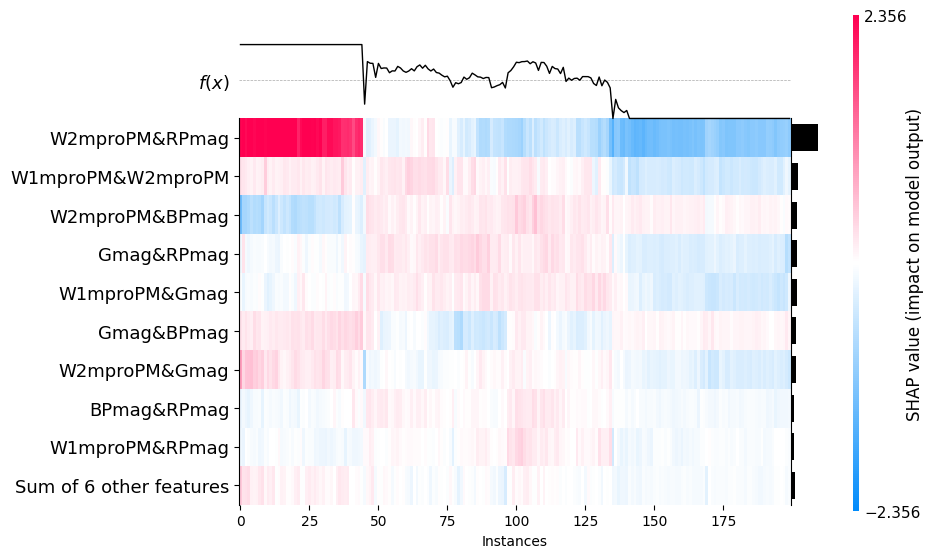

In [37]:
shap.plots.heatmap(shap_values)

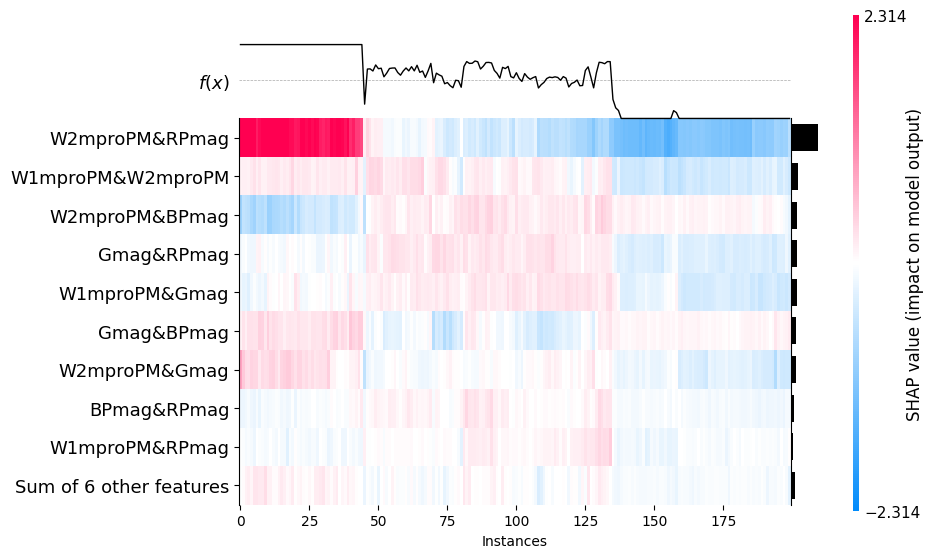

In [38]:
shap.plots.heatmap(shap_values_1)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


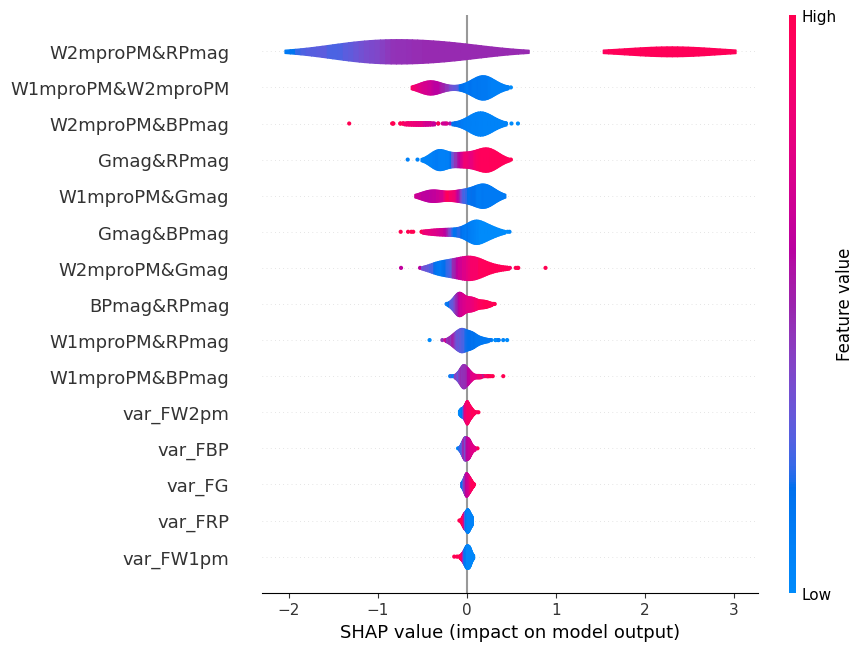

In [66]:
shap.plots.violin(shap_values)

In [28]:
shap_values[0]

.values =
array([ 0.00173889, -0.00346759, -0.01073736,  0.02292066, -0.00142215,
        0.2298579 ,  0.26248422,  0.04673874,  0.06033033, -0.02283812,
        0.24109178, -0.53074855, -0.14562305,  0.09562395, -0.02954917])

.base_values =
array([3.61395549])

.data =
array([ 0.0570879 ,  0.08168827,  0.19436402,  0.34222335,  0.29455799,
        0.07221206, -5.90738542, -4.52758142, -3.31184894, -5.97959748,
       -4.59979348, -3.384061  ,  1.37980401,  2.59553649,  1.21573248])

In [24]:
shap_values[0, :]

.values =
array([ 0.00173889, -0.00346759, -0.01073736,  0.02292066, -0.00142215,
        0.2298579 ,  0.26248422,  0.04673874,  0.06033033, -0.02283812,
        0.24109178, -0.53074855, -0.14562305,  0.09562395, -0.02954917])

.base_values =
array([3.61395549])

.data =
array([ 0.0570879 ,  0.08168827,  0.19436402,  0.34222335,  0.29455799,
        0.07221206, -5.90738542, -4.52758142, -3.31184894, -5.97959748,
       -4.59979348, -3.384061  ,  1.37980401,  2.59553649,  1.21573248])

In [13]:
shap_values

.values =
array([[ 0.00173889, -0.00346759, -0.01073736, ..., -0.14562305,
         0.09562395, -0.02954917],
       [ 0.00755325, -0.03882675,  0.02552895, ..., -0.1595758 ,
         0.0415589 ,  0.0578264 ],
       [-0.0359397 ,  0.13105443, -0.01763806, ...,  0.28326654,
        -0.1370922 , -0.19416574],
       ...,
       [ 0.00130436, -0.00052673, -0.00663397, ...,  0.06565334,
        -0.35912087, -0.08535226],
       [-0.00311409, -0.01404963,  0.01009396, ..., -0.01501787,
         0.26860541,  0.14209418],
       [ 0.00231772, -0.00419099,  0.00954778, ..., -0.19616987,
         0.20744554,  0.09300207]])

.base_values =
array([[3.61395549],
       [3.61395549],
       [3.61395549],
       [3.61395549],
       [3.61395549],
       [3.61395549],
       [3.61395549],
       [3.61395549],
       [3.61395549],
       [3.61395549],
       [3.61395549],
       [3.61395549],
       [3.61395549],
       [3.61395549],
       [3.61395549],
       [3.61395549],
       [3.61395549],
    